# Disaster Response Message Classification

Disaster Response Message Classification sebuah model mechine learning supervised yang digunakan untuk melakukan klasifikasi data teks. Bertujuan untuk memberikan respon terkait dengan informasi yang diterima dari teks yang berhubungan dengan klasifikasi bantuan bencana yang dibutuhkan, sehingga organisasi penganan bencana alam terkait dapat memberikan bantuan sesuai dengan kebutuhan di lokasi.

## Import Libraries

Ada beberapa library yang perlu anda install seperti library `contractions` digunakan untuk menampilkan kata utuh dari kalimat yang terdapat slang/singkatan seperti `you'll -> you will, A.S.A.P -> as soon as possible`. anda dapat mengintall menggunakan `$ pip install contractions`. Anda juga perlu menginstall library `nltk` menggunakan anaconda prompt dengan `conda install -c anaconda nltk`.

In [1]:
# !pip install contractions

     |████████████████████████████████| 321 kB 5.1 MB/s 
     |████████████████████████████████| 284 kB 56.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=5bb6193a6028ddaa396763abc81ba7a7ce0f94f6cfd66b68e35559008474bba0
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import re
import string
import contractions

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Dataset

Data diperoleh dari data disaster response message yang dikumpulkan oleh figure-eight atau yang sekarang dikenal dengan [appen](https://appen.com/). 

Data terdiri dari 2 file. Yang pertaman file **message.csv** merupakan file feture yang berisi kolom id yang merupakan unique id tiap message, kolom message yang berisi message yang sudah diterjemahkan dalam bahasa inggris, kolom original yang berisi message dengan bahasa asli message tersebut diperoleh, kolom genre yang merupakan jenis pesan.

Kemudian file kedua adalah **categories.csv** yang merupakan file target yang berisi kolom idi yang merupakan unique id tiap message, dan kolom categories yang merupakan informasi category pesan tersebut. Terdapat 36 category yang berbeda.

Jumlah data sebanyak *26.248* messasge.

In [4]:
#Open data
messages = pd.read_csv("data/messages.csv")
categories = pd.read_csv("data/categories.csv")

In [5]:
messages

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct
...,...,...,...,...
26243,30261,The training demonstrated how to enhance micro...,NaN,news
26244,30262,A suitable candidate has been selected and OCH...,NaN,news
26245,30263,"Proshika, operating in Cox's Bazar municipalit...",NaN,news
26246,30264,"Some 2,000 women protesting against the conduc...",NaN,news


In [6]:
categories

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...
...,...,...
26243,30261,related-0;request-0;offer-0;aid_related-0;medi...
26244,30262,related-0;request-0;offer-0;aid_related-0;medi...
26245,30263,related-1;request-0;offer-0;aid_related-0;medi...
26246,30264,related-1;request-0;offer-0;aid_related-1;medi...


In [7]:
sample_category = categories.loc[20000]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-1;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
Sensitive to nationalist opinion and its long-running battle with armed separatists in Aceh, the Indonesian government has told foreign troops to leave by Mar. 26.


In [8]:
sample_category = categories.loc[900]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-1
My wife understands better. So, tell us what to do. It doesnt sound like they need help, but are available to help


In [9]:
sample_category = categories.loc[10000]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-1;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-0;storm-0;fire-0;earthquake-1;cold-0;other_weather-0;direct_report-0
U can call n about Haiti Earthquake n give ur thought right now. On 99 Jamz. call now. I m here helping w the c.. http loopt.us YhQFkw.t


## Exploratory Data Analysis


Pertama kita ingine mengetahui pada file message.csv, ada berapa jenis genre, dan jumlah tiap genre yang ada

In [10]:
messages.genre.unique()

array(['direct', 'social', 'news'], dtype=object)

In [11]:
genre_count = messages.groupby("genre").count()
genre_count

,id,message,original
genre,,,
direct,10782,10782,10184
news,13068,13068,0
social,2398,2398,0


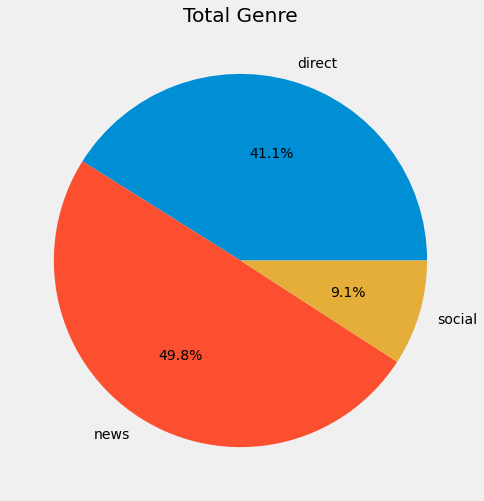

In [12]:
plt.figure(figsize=(8,8))
plt.pie(genre_count.message, autopct="%1.1f%%", labels=genre_count.index)
plt.title("Total Genre")
plt.show()

Terdapat 3 unique genre yaitu direct yang berarti message langsung yang dikirim, news yang berarti message dari berita, dan social yang berarti message dari social media. Untuk message yang paling banyak adalah genre news dengan 13068 messages, direct sebanyak 10782 messages, dan social sebanyak 2398 messages. Selanjutnya kita coba tampilkan contoh pesan tiap genre tersebut.

In [13]:
messages[messages["genre"] == "direct"]

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct
...,...,...,...,...
12367,14675,"shikarpur: Volunteers needed, food and medical...",shikarpur mein swanyasevak ki avyashaktha he.k...,direct
12368,14676,"Dadu: Needs water, food, medicines. boats","JO KO KHANA, PAANI, DAWAYIAN, NAOV CHAHIYE.",direct
12369,14678,Abarho Gotki: No aid being reached to the area,NaN,direct
12370,14679,Umer kot: Sindh: Shelter and Camp needed as pe...,"Umer kot: Sindh: logon ko rehne ke liye ghar,s...",direct


In [14]:
sample_category = categories.loc[14678]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
The team of experts from the US Geological Survey, including Andy Lockhart, Jeff Marso and Elliot Endo will work with their PNG counterparts Ima Itikarai, John Bosco and Jonathan Kuduon to install seismic stations, not only on Mount Pago, but on other volcanoes as well.


In [15]:
sample_category = categories.loc[12370]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-1;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-1;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-1;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-1;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-1
Umer kot: Sindh: Shelter and Camp needed as people are stranded due to flood:


In [16]:
messages[messages["genre"] == "news"]

,id,message,original,genre
13180,15730,UNICEF is also upgrading solid waste managemen...,NaN,news
13181,15731,China periodically faces spills into rivers th...,NaN,news
13182,15732,"DATO' SRI MOHD NAJIB BIN TUN HAJI ABDUL RAZAK,...",NaN,news
13183,15733,This is a vital step in ensuring respect for h...,NaN,news
13184,15734,The pumping of contaminated water from the bas...,NaN,news
...,...,...,...,...
26243,30261,The training demonstrated how to enhance micro...,NaN,news
26244,30262,A suitable candidate has been selected and OCH...,NaN,news
26245,30263,"Proshika, operating in Cox's Bazar municipalit...",NaN,news
26246,30264,"Some 2,000 women protesting against the conduc...",NaN,news


In [17]:
sample_category = categories.loc[26246]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-1;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.


In [18]:
sample_category = categories.loc[13182]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
DATO' SRI MOHD NAJIB BIN TUN HAJI ABDUL RAZAK, Prime Minister of Malaysia, said that five years ago he had called for a global movement of moderates of all religions and of all countries to marginalize extremists and shape an agenda towards peace and pragmatism.


In [19]:
messages[messages["genre"] == "social"]

,id,message,original,genre
9902,11186,My thoughts and prayers go out to all the live...,NaN,social
9903,11188,I m sorry for the poor people in Haiti tonight...,NaN,social
9904,11189,RT selenagomez UNICEF has just announced an em...,NaN,social
9905,11192,lilithia yes 5.2 magnitude earthquake hit mani...,NaN,social
9906,11193,RT TheNewsBlotter RT caribnews On Call Interna...,NaN,social
...,...,...,...,...
13175,15723,Gas rationing finally hits NY. I haven't been ...,NaN,social
13176,15724,TTCustomerCare Hope your NY team is safe. Any ...,NaN,social
13177,15727,Bringing in a huge garbage bag of clothes for ...,NaN,social
13178,15728,AMAZING NY morning. Brainstorming breakfast at...,NaN,social


In [20]:
sample_category = categories.loc[13178]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-0;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
AMAZING NY morning. Brainstorming breakfast at The Smile! #promgirl247 #nyc #tgifLOL. My paycheck will be $165 next pay day.. #fuckyousandy


In [21]:
sample_category = categories.loc[9906]
print(sample_category.categories)
print(messages.loc[messages.id == sample_category.id, "message"].item())

related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-1;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-0;storm-0;fire-0;earthquake-1;cold-0;other_weather-0;direct_report-0
RT TheNewsBlotter RT caribnews On Call International opens #Haiti earthquake emergency hotline for those with families friends in r ..


Kita akan coba check pada kolom id apakah terdapat data yang sama

In [22]:
messages.id.nunique()

26180

dari 26248 data, hanya ada 26180 id. Ini berarti terdapat id yang sama. kita akan coba tampilkan pesan dan categories untuk id yang sama

In [23]:
messages[messages.duplicated(subset="id", keep=False)]

,id,message,original,genre
162,202,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct
163,202,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct
655,804,elle est vraiment malade et a besoin d'aide. u...,she is really sick she need your help. please ...,direct
656,804,elle est vraiment malade et a besoin d'aide. u...,she is really sick she need your help. please ...,direct
709,862,What is the address of the radio station? I as...,Ki adres radyo a? Paske m bezwen al depoze dos...,direct
...,...,...,...,...
24856,28687,"At present, UNHCR has 2,500 additional tents a...",NaN,news
25155,29022,"In a field in Jallouzai, just inside Pakistan,...",NaN,news
25156,29022,"In a field in Jallouzai, just inside Pakistan,...",NaN,news
25241,29119,Most victims (90 per cent) show little or no s...,NaN,news


In [24]:
sample_category = categories.loc[25155]
print(sample_category.categories)
print(messages.loc[25155])

related-1;request-1;offer-0;aid_related-1;medical_help-0;medical_products-1;search_and_rescue-0;security-0;military-0;child_alone-0;water-1;food-0;shelter-1;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
id                                                      29022
message     In a field in Jallouzai, just inside Pakistan,...
original                                                  NaN
genre                                                    news
Name: 25155, dtype: object


In [25]:
sample_category = categories.loc[25156]
print(sample_category.categories)
print(messages.loc[25156])

related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-1;search_and_rescue-0;security-0;military-0;child_alone-0;water-1;food-0;shelter-1;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
id                                                      29022
message     In a field in Jallouzai, just inside Pakistan,...
original                                                  NaN
genre                                                    news
Name: 25156, dtype: object


Untuk id yang sama, memiliki message yang sama, tetapi terdapat categories yang berbeda untuk id yang sama. Karena itu kita bisa melakukan penghapusan baris untuk id yang sama. Ini dilakukan untuk mengurangi kebingungan model dalam mempelajari data. kita menggunakan `keep = First`

In [26]:
messages.drop_duplicates(subset="id", keep="first", inplace=True)

In [27]:
messages

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct
...,...,...,...,...
26243,30261,The training demonstrated how to enhance micro...,NaN,news
26244,30262,A suitable candidate has been selected and OCH...,NaN,news
26245,30263,"Proshika, operating in Cox's Bazar municipalit...",NaN,news
26246,30264,"Some 2,000 women protesting against the conduc...",NaN,news


Selanjutnya kita akan melakukan eksplorasi pada file categories.csv. karena pada file categories, untuk categories masih menjadi 1 kolom pada kolom categories, maka kita perlu memisahkannya untuk memudahkan menjadi features ketika permodelan

In [28]:
def category_split(idx):
  """
  Split the categories columns into new columns for each categories based on the index.
  Return array of 1 or 0 for each categories.
  1 means messages is in categories, 0 otherwise
  """
  sample_category = categories.loc[idx]
  df = pd.DataFrame([category.split("-") for category in sample_category.categories.split(";")], columns=["category", "value"])
  return df.value.values

In [29]:
category_split(2)

array(['1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], dtype=object)

In [30]:
category = pd.DataFrame(category_split(x) for x in categories.index) #split categories for each id

In [31]:
#define columns name for categories
col_names_cat = categories.loc[1]
col_names = pd.DataFrame([category.split("-") for category in col_names_cat.categories.split(";")], columns=["category", "value"])
col_names = col_names.category.values
col_names = list(col_names)
col_names

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [32]:
category.columns = col_names
category

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26245,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26246,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
category.insert(0, "id", list(categories.id.values))
category

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,30261,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26244,30262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26245,30263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26246,30264,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Kita juga akan menghapus baris dengan id yang sama dan menggunakan `keep = first`

In [34]:
category[category.duplicated(subset="id", keep=False)]

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
162,202,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
163,202,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
655,804,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
656,804,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
709,862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24856,28687,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25155,29022,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25156,29022,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25241,29119,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
category.drop_duplicates(subset="id", keep="first", inplace=True)

In [36]:
category

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,30261,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26244,30262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26245,30263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26246,30264,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Setelah kita memisahkan tiap kategori ke kolom baru, selanjutnya kita ingin mengetahui berapakah jumlah respon `1` tiap kategori.

In [37]:
category_float = category.astype(float).drop(columns="id")
category_float.sum()

related                   20252.0
request                    4464.0
offer                       118.0
aid_related               10841.0
medical_help               2081.0
medical_products           1311.0
search_and_rescue           724.0
security                    471.0
military                    859.0
child_alone                   0.0
water                      1669.0
food                       2917.0
shelter                    2308.0
clothing                    404.0
money                       603.0
missing_people              298.0
refugees                    874.0
death                      1192.0
other_aid                  3441.0
infrastructure_related     1705.0
transport                  1199.0
buildings                  1331.0
electricity                 532.0
tools                       159.0
hospitals                   283.0
shops                       120.0
aid_centers                 309.0
other_infrastructure       1151.0
weather_related            7286.0
floods        

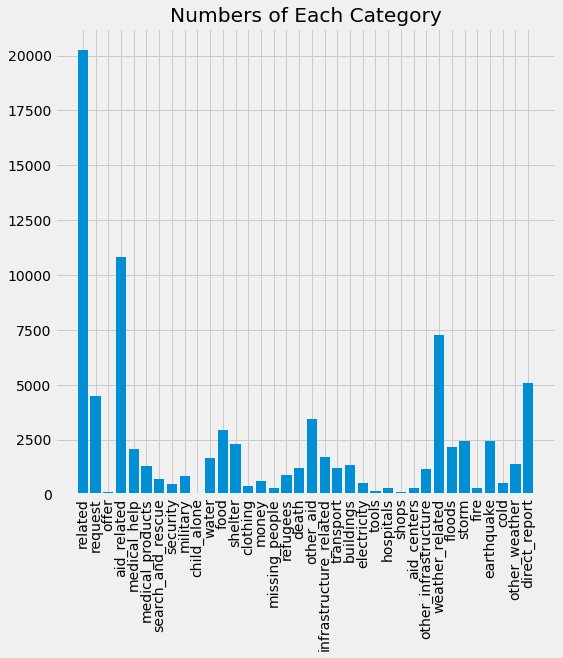

In [38]:
plt.figure(figsize=(8,8))
plt.bar(category_float.columns, category_float.sum())
plt.xticks(rotation=90)
plt.title("Numbers of Each Category")
plt.show()

Dapat dilihat bahwa category related yang paling banyak respon `1`, lebih dari 20000, berarti bahwa banyak message yang berkaitan dengan bencana alam. Category terbanyak selanjutnya adalah aid_related, weather_related, dan direct_report.

Sedangkan untuk category yang paling sedikit respon `1` adalah child_alone dengan nilai 0. Kemudian category shops, offer, dan tools.

Category yang lain cenderung berjumlah rata-rata.

## Data Preparation


Sebelum kita melakukan modelling. kita perlu menyiapkan data terlebih dahulu. yang pertama adalah menentukan X, kita menggunakan fitur message saja, karena datanya lengkap dan menggunakan bahasa inggris. Kemudian untuk y kita menggunakan kolom categories.

In [39]:
#Get only message column
X = messages[["message"]]
X

,message
0,Weather update - a cold front from Cuba that c...
1,Is the Hurricane over or is it not over
2,Looking for someone but no name
3,UN reports Leogane 80-90 destroyed. Only Hospi...
4,"says: west side of Haiti, rest of the country ..."
...,...
26243,The training demonstrated how to enhance micro...
26244,A suitable candidate has been selected and OCH...
26245,"Proshika, operating in Cox's Bazar municipalit..."
26246,"Some 2,000 women protesting against the conduc..."


Untuk target atau y kita menggunakan categories yang sudah dipisahkan

In [40]:
y = category.drop(columns="id")
y

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26245,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26246,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Pada category `related` terdapat 3 n-unique yaitu 0, 1, 2. Untuk itu kita akan merubah semua yang 2 menjadi 0.

In [41]:
y["related"] = y["related"].apply(lambda x: '0' if x == '2' else x)

Melakukan text cleaning

In [42]:
def elongated_word(word):
    """
    Replaces an elongated word with its basic form, unless the word exists in the lexicon 
    """
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if (len(word)>2 and word[0] != '$'):#if not Stock Market symbol
        if wn.synsets(word):
            return word
        repl_word = repeat_regexp.sub(repl, word)
        if repl_word != word:      
            return elongated_word(repl_word)
        else:       
            return repl_word
    else:
        return word

In [43]:
def text_cleaner(text):
    '''
    clean input sentence  
    '''
    mention_pat= r'@[A-Za-z0-9_]+'
    mention_2_pat= r'@[A-Za-z0-9_]+:\s'
    retweet_pat= r'^RT +'
    http_pat = r'https?://[^ ]+'
    www_pat = r'www.[^ ]+'

    #Remove mention
    text = re.sub(mention_2_pat,'', text)
    text = re.sub(mention_pat,'', text)

    #Remove retweet
    text = re.sub(retweet_pat,'',text)

    #Remove url
    text = re.sub(http_pat, '', text)
    text = re.sub(www_pat, '', text)
    
    #Transform contracted and slang words into normal words
    #e.g yall're happy now -> you all are happy now
    text = contractions.fix(text)

    #Remove newline characters 
    text = text.replace('\n', ' ') 

    #Remove multiple spaces
    text = re.sub("\s\s+" , " ", text)

    #Remove hashtag
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    text = " ".join(word.strip() for word in re.split('#|_', text)) #remove just the hashtags (#) symbol from words in the middle of the sentence

    #Remove non utf8/ascii characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    #Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    #Remove elongated words 
    # e.g. "nooooo" -> "no"
    test_split = text.split()
    test_split = [elongated_word(x) if not x.isdigit() else x for x in test_split]
    text = " ".join(test_split)
    #Lowercase
    text = text.lower()

    #Remove any spaces at the start or end of the text
    text = text.strip()

    return text

In [44]:
print(X['message'].iloc[9906])
print(text_cleaner(X['message'].iloc[9906]))
print(y.iloc[9906])

Haiti Earthquake Launching Ushahidi platform http haiti.ushahidi.com we re customize as ASAP #Haiti
haiti earthquake launching ushahidi platform http haitiushahidicom we re customize as as soon as possible
related                   1
request                   0
offer                     0
aid_related               0
medical_help              0
medical_products          0
search_and_rescue         0
security                  0
military                  0
child_alone               0
water                     0
food                      0
shelter                   0
clothing                  0
money                     0
missing_people            0
refugees                  0
death                     0
other_aid                 0
infrastructure_related    0
transport                 0
buildings                 0
electricity               0
tools                     0
hospitals                 0
shops                     0
aid_centers               0
other_infrastructure      0
weather_re

In [45]:
print(X['message'].iloc[12370])
print(text_cleaner(X['message'].iloc[12370]))
print(y.iloc[12370])

ictoriabrielle it's supposed to storm tonight@lescarpeeyborsa mao gyud. The last storm, nabahaan ila house RG. Til now wala pa naayo.
ictoriabriele it is supposed to storm tonight mao gyud the last storm nabahan ila house rg til now wala pa nayo
related                   1
request                   0
offer                     0
aid_related               0
medical_help              0
medical_products          0
search_and_rescue         0
security                  0
military                  0
child_alone               0
water                     0
food                      0
shelter                   0
clothing                  0
money                     0
missing_people            0
refugees                  0
death                     0
other_aid                 0
infrastructure_related    0
transport                 0
buildings                 0
electricity               0
tools                     0
hospitals                 0
shops                     0
aid_centers               

In [46]:
#apply the text cleaner function to all message

X["clean_message"] = X["message"].apply(text_cleaner)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
X

,message,clean_message
0,Weather update - a cold front from Cuba that c...,weather update a cold front from cuba that cou...
1,Is the Hurricane over or is it not over,is the hurricane over or is it not over
2,Looking for someone but no name,looking for someone but no name
3,UN reports Leogane 80-90 destroyed. Only Hospi...,un reports leogane 8090 destroyed only hospita...
4,"says: west side of Haiti, rest of the country ...",says west side of haiti rest of the country to...
...,...,...
26243,The training demonstrated how to enhance micro...,the training demonstrated how to enhance micro...
26244,A suitable candidate has been selected and OCH...,a suitable candidate has been selected and och...
26245,"Proshika, operating in Cox's Bazar municipalit...",proshika operating in coxs bazar municipality ...
26246,"Some 2,000 women protesting against the conduc...",some 2000 women protesting against the conduct...


Next we will remove stopwords using NLTK package

In [48]:
stopwords_list = stopwords.words('english')
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [49]:
def remove_stopwords(text):
  """
  Removing stopwords

  """
  text_split = text.split() #split text by space into a list of strings
  text_split = [x for x in text_split if x not in stopwords_list] #filter out stopwords
  text = ' '.join(text_split) #join list of strings into a string
  return text.strip()

In [50]:
#Remove stopwords from clean_message and save to new columns
X["cleaner_message"] = X["clean_message"].apply(remove_stopwords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
X

,message,clean_message,cleaner_message
0,Weather update - a cold front from Cuba that c...,weather update a cold front from cuba that cou...,weather update cold front cuba could pass haiti
1,Is the Hurricane over or is it not over,is the hurricane over or is it not over,hurricane
2,Looking for someone but no name,looking for someone but no name,looking someone name
3,UN reports Leogane 80-90 destroyed. Only Hospi...,un reports leogane 8090 destroyed only hospita...,un reports leogane 8090 destroyed hospital st ...
4,"says: west side of Haiti, rest of the country ...",says west side of haiti rest of the country to...,says west side haiti rest country today tonight
...,...,...,...
26243,The training demonstrated how to enhance micro...,the training demonstrated how to enhance micro...,training demonstrated enhance micronutrient pr...
26244,A suitable candidate has been selected and OCH...,a suitable candidate has been selected and och...,suitable candidate selected ocha jakarta curre...
26245,"Proshika, operating in Cox's Bazar municipalit...",proshika operating in coxs bazar municipality ...,proshika operating coxs bazar municipality 5 u...
26246,"Some 2,000 women protesting against the conduc...",some 2000 women protesting against the conduct...,2000 women protesting conduct elections tearga...


Selanjutnya kita akan membagi X dan y kedalam data train dan data test terlebih dahulu

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=11)

print("len(X_train) =", len(X_train), "len(X_dev) =", len(X_test))
print("len(y_train) =", len(y_train), "len(y_dev) =", len(y_test))

len(X_train) = 20944 len(X_dev) = 5236
len(y_train) = 20944 len(y_dev) = 5236


In [53]:
y_train.shape

(20944, 36)

In [54]:
X_train.shape

(20944, 3)

untuk memasukkan kalimat atau string `str` ke dalam model, kita tidak bisa langsung memasukkannya ke dalam model. Kita harus ubah data text tersebut ke dalam bentuk vektor (integer `int` atau float `folat`) terlebih dahulu. Tahap ini adalah taham tokenization. Kita akan mengubah data text ke dalam vector, kita menggunakan BoW dan TF-IDF

### BoW

Bag of Word menggunakan `CountVectorizer` dengan melakukan tokenization dan juga membuat sebuah vocabulary dari kata yang ada dalam data. Jadi untuk setiap kata yang berbeda akan dihitung jumlahnya dalam data tersebut. Semakin sering kata tersebut muncul pada kalimat dalam data, maka nilainya akan semakin besar. Dan semakin banyak kata yang berbeda, vocabulary juga akan semakin besar.

In [55]:
BoW = CountVectorizer()
X_train_BoW = BoW.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_BoW = BoW.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [56]:
print(X_train_BoW.shape)

(20944, 33497)


let's set the min_df 

In [57]:
BoW_df = CountVectorizer(min_df=5) #When building the vocabulary ignore terms that have a document frequency strictly lower than min_df.
X_train_BoW_df = BoW_df.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_BoW_df = BoW_df.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [58]:
print(X_train_BoW_df.shape)

(20944, 7138)


let's set the n-gram

In [59]:
BoW_gram = CountVectorizer(ngram_range=(1,2)) ##add bi-gram to our vocab
X_train_BoW_gram = BoW_gram.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_BoW_gram = BoW_gram.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [60]:
print(X_train_BoW_gram.shape)

(20944, 235101)


Now, we set the min_df and n-gram together

In [61]:
BoW_mix = CountVectorizer(min_df=5, ngram_range=(1,2))
X_train_BoW_mix = BoW_mix.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_BoW_mix = BoW_mix.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [62]:
print(X_train_BoW_mix.shape)

(20944, 10673)


### TF-IDF

TF-IDF proses tokenizationnya sama dengan BoW, yang berbeda adalah bagaimana TF-IDF memberikan nilai yang lebih kecil pada kata yang sering muncul pada kalimat dalam data. Semakin sering kata tersebut muncul, semakin kecil nilainya, ini sangat berguna untuk mengeliminasi kata yang sering muncul sehingga kata tersebut dianggap tidak terlalu memberi pengaruh pada kalimat.

In [63]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_tfidf = tfidf.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [64]:
print(X_train_tfidf.shape)

(20944, 33497)


let's set the min_df

In [65]:
tfidf_df = TfidfVectorizer(min_df=10) # When building the vocabulary ignore terms that have a document frequency strictly lower than min_df.
X_train_tfidf_df = tfidf_df.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_tfidf_df = tfidf_df.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [66]:
print(X_train_tfidf_df.shape)

(20944, 4231)


let's set the n-gram

In [67]:
tfidf_gram = TfidfVectorizer(ngram_range=(1,3)) # When building the vocabulary ignore terms that have a document frequency strictly lower than min_df.
X_train_tfidf_gram = tfidf_gram.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_tfidf_gram = tfidf_gram.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [68]:
print(X_train_tfidf_gram.shape)

(20944, 465904)


In [69]:
tfidf_mix = TfidfVectorizer(min_df=10, ngram_range=(1,2))
X_train_tfidf_mix = tfidf_mix.fit_transform(X_train['cleaner_message'].to_list()) #fit and transform on train data
X_test_tfidf_mix = tfidf_mix.transform(X_test['cleaner_message'].to_list()) #used the fitted vectorizer and transform on test data

In [70]:
print(X_train_tfidf_mix.shape)

(20944, 5272)


Hasil Vectorizer BoW dan TF-IDF dengan nilai parameter yang sama, menghasilkan shape yang sama, kita akan ubah nilai min_df dan n-gram untuk TF-IDF sebagai pembanding pada model.

## Modelling
Kita akan mencoba menggunakan model **Decision Tree dan Random Forest**. Dan untuk Classification report kita akan membuat function untuk mengakses tiap category. Untuk menghemat waktu, classification_report hanya akan menggunakan kolom `'related', 'request', 'aid_related', 'other_aid', 'direct_report'` karena untuk kolom category yang lain, nilai accuracy-nya sudah diatas 0.92, nilainya cenderung sama atau hanya berbeda sekitar .1, dan tidak berubah walaupun berbeda vectorizer dan model.

### Decision Tree

Kita akan mencoba menggunakan `Decission Tree` pada data BoW dan TF-IDF

In [71]:
X_train = X_train_BoW_gram
X_test = X_test_BoW_gram

dtree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
test_pred = dtree.predict(X_test)

df_pred = pd.DataFrame(test_pred, columns=y_train.columns)

target = ['related', 'request', 'aid_related', 'other_aid', 'direct_report']
for category in target:
  print(category)
  print(classification_report(y_test[category], df_pred[category]))

related
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      1245
           1       0.88      0.82      0.85      3991

    accuracy                           0.77      5236
   macro avg       0.70      0.72      0.71      5236
weighted avg       0.79      0.77      0.78      5236

request
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4343
           1       0.65      0.51      0.57       893

    accuracy                           0.87      5236
   macro avg       0.77      0.72      0.74      5236
weighted avg       0.86      0.87      0.86      5236

aid_related
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      3027
           1       0.74      0.51      0.60      2209

    accuracy                           0.72      5236
   macro avg       0.72      0.69      0.69      5236
weighted avg       0.72      0.72      0.70   

In [72]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

setelah beberapa percobaan, diketahui untuk `Decision Tree` vectorizer yang terbaik adalah BoW yang menggunakan paramater `n-gram = (1,2)`

### Random Forest
Kita akan mencoba menggunakan `RandomForest` pada data BoW dan TF-IDF

In [73]:
X_train = X_train_tfidf_df
X_test = X_test_tfidf_df

rf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
test_pred = rf.predict(X_test)

df_pred = pd.DataFrame(test_pred, columns=y_train.columns)

target = ['related', 'request', 'aid_related', 'other_aid', 'direct_report']
for category in target:
  print(category)
  print(classification_report(y_test[category], df_pred[category]))

related
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1245
           1       0.87      0.91      0.89      3991

    accuracy                           0.83      5236
   macro avg       0.76      0.73      0.74      5236
weighted avg       0.82      0.83      0.82      5236

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4343
           1       0.82      0.52      0.63       893

    accuracy                           0.90      5236
   macro avg       0.86      0.75      0.79      5236
weighted avg       0.89      0.90      0.89      5236

aid_related
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      3027
           1       0.80      0.56      0.66      2209

    accuracy                           0.76      5236
   macro avg       0.77      0.73      0.73      5236
weighted avg       0.76      0.76      0.75   

In [74]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

setelah beberapa percobaan, untuk Random Forest yang terbaik adalah dengan vectorizer `TF-IDF` dengan parameter min_df=10.

### Hyperparameter Tuning

we try to tune the parameter so it can have a better accuracy

### Decision Tree

In [75]:
max_depth = (None, 100, 200)
min_sample_split = (2, 20, 40)
min_sample_leaf = (1, 10, 20)


grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid={
        "max_depth": max_depth,
        "min_samples_split": min_sample_split,
        "min_samples_leaf": min_sample_leaf,
    }
)


grid_search.fit(X_train_BoW_gram, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise Va

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': (None, 100, 200),
                         'min_samples_leaf': (1, 10, 20),
                         'min_samples_split': (2, 20, 40)})

In [76]:
grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [77]:
X_train = X_train_BoW_gram
X_test = X_test_BoW_gram

dtree = DecisionTreeClassifier(min_samples_leaf=1, min_samples_split=2, random_state=0).fit(X_train, y_train)
test_pred = dtree.predict(X_test)

df_pred = pd.DataFrame(test_pred, columns=y_train.columns)

target = ['related', 'request', 'aid_related', 'other_aid', 'direct_report']
for category in target:
  print(category)
  print(classification_report(y_test[category], df_pred[category]))

related
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      1245
           1       0.88      0.82      0.85      3991

    accuracy                           0.77      5236
   macro avg       0.70      0.72      0.71      5236
weighted avg       0.79      0.77      0.78      5236

request
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4343
           1       0.65      0.51      0.57       893

    accuracy                           0.87      5236
   macro avg       0.77      0.72      0.74      5236
weighted avg       0.86      0.87      0.86      5236

aid_related
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      3027
           1       0.74      0.51      0.60      2209

    accuracy                           0.72      5236
   macro avg       0.72      0.69      0.69      5236
weighted avg       0.72      0.72      0.70   

Untuk **Decision Tree**, berdasarkan GridSearch, parameter yang palin optimal adalah `'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2`

### Random Forest

In [78]:
max_depth = (None, 100, 200)
min_sample_split = (2, 20, 40)
min_sample_leaf = (1, 10, 20)


grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "max_depth": max_depth,
        "min_samples_split": min_sample_split,
        "min_samples_leaf": min_sample_leaf,
    }
)


grid_search.fit(X_train_tfidf_df, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise Va

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': (None, 100, 200),
                         'min_samples_leaf': (1, 10, 20),
                         'min_samples_split': (2, 20, 40)})

In [79]:
grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [80]:
X_train = X_train_tfidf_df
X_test = X_test_tfidf_df

rf = RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, random_state=0).fit(X_train, y_train)
test_pred = rf.predict(X_test)

df_pred = pd.DataFrame(test_pred, columns=y_train.columns)

target = ['related', 'request', 'aid_related', 'other_aid', 'direct_report']
for category in target:
  print(category)
  print(classification_report(y_test[category], df_pred[category]))

related
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1245
           1       0.87      0.91      0.89      3991

    accuracy                           0.83      5236
   macro avg       0.76      0.73      0.74      5236
weighted avg       0.82      0.83      0.82      5236

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4343
           1       0.82      0.52      0.63       893

    accuracy                           0.90      5236
   macro avg       0.86      0.75      0.79      5236
weighted avg       0.89      0.90      0.89      5236

aid_related
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      3027
           1       0.80      0.56      0.66      2209

    accuracy                           0.76      5236
   macro avg       0.77      0.73      0.73      5236
weighted avg       0.76      0.76      0.75   

Untuk **Random Forest**, berdasarkan GridSearch parameter yang paling optimal adalah `'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2`

## Kesimpulan

Berdasarkan nilai accuracy menggunakan classification_report, model yang paling baik digunakan dalam data adalah **Random Forest** dengan parameter `'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2`. Untuk pengolahan featurnya menggunakan **TF-IDF** dengan parameter `min_df=10`. 

Kekurangan dari model ini adalah tidak berimbangnya jumlah informasi untuk tiap category, sehingga mungkin untuk beberapa category tidak dapat melakukan prediksi dengan tepat. Contohnya seperti pada category `child_alone` dimana dari data yang tersedia, seluruh data memiliki nilai 0. Sehingga, ketika ada data text baru yang memiliki informasi child_alone, model tidak dapat mengklasifikasikannya masuk ke dalam category `child_alone`.

In [81]:
for category in y.columns:
  print(category)
  print(classification_report(y_test[category], df_pred[category], zero_division=0))

related
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1245
           1       0.87      0.91      0.89      3991

    accuracy                           0.83      5236
   macro avg       0.76      0.73      0.74      5236
weighted avg       0.82      0.83      0.82      5236

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4343
           1       0.82      0.52      0.63       893

    accuracy                           0.90      5236
   macro avg       0.86      0.75      0.79      5236
weighted avg       0.89      0.90      0.89      5236

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5205
           1       0.00      0.00      0.00        31

    accuracy                           0.99      5236
   macro avg       0.50      0.50      0.50      5236
weighted avg       0.99      0.99      0.99      523

dengan menggunakan model tersebut, untuk nilai accuracy rata-ratanya adalah 0.95
selanjutnya kita akan mencoba memprediksi untuk teks random, apakah model dapat melakukan prediksi dengan optimal.

In [82]:
testing_text = ["the eruption of Semeru, Java's tallest mountain, ejected ash clouds and pyroclastic flows that killed at least 46 people and left several missing, while thousands were displaced"]
testing_text = tfidf_df.transform(testing_text)
test_pred = rf.predict(testing_text)
test_pred = pd.DataFrame(test_pred, columns=y.columns)
test_pred

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [83]:
testing_text = ["About 24,000 people have been evacuated and two children killed in floods on Indonesia's Sumatra island, officials said Tuesday, with environmental campaigners blaming deforestation for worsening the disaster"]
testing_text = tfidf_df.transform(testing_text)
test_pred = rf.predict(testing_text)
test_pred = pd.DataFrame(test_pred, columns=y.columns)
test_pred

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [84]:
testing_text = ["David Bowie’s extensive music catalog is sold to Warner"]
testing_text = tfidf_df.transform(testing_text)
test_pred = rf.predict(testing_text)
test_pred = pd.DataFrame(test_pred, columns=y.columns)
test_pred

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
testing_text = ["""Up to 6 inches of snow is expected to fall in parts of 
Massachusetts on Friday. The fast-moving storm is expected to last from 3am to 3pm, according to @7News
meteorologists."""]
testing_text = tfidf_df.transform(testing_text)
print(testing_text.shape)
test_pred = rf.predict(testing_text)
test_pred = pd.DataFrame(test_pred, columns=y.columns)
test_pred

(1, 4231)


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Dari beberapa percobaan di atas, dapat dilihat bahwa model cukup baik dalam melakukan klasifiksai, terutama untuk klasifikasi category `related` dimana nilai 1 berarti data tersebut berhubungan dengan disaster response, dan 0 berarti tidak berhubungan.